In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from tensorflow.keras.datasets import fashion_mnist


In [3]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 2us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Normalize from from 0 to 255 to [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

In [5]:
# Convert 2D images (28x28 pixels) into 1D vectors (784 values)
train_flat = train_images.reshape(len(train_images), -1)  # shape: (60000, 784)
test_flat = test_images.reshape(len(test_images), -1)    # shape: (10000, 784)

In [8]:
# Check the Result
print("Shape before flattening:", train_images.shape)  # (60000, 28, 28)
print("Shape after flattening:", train_flat.shape)     # (60000, 784)

print("Pixel range:", train_images.min(), "to", train_images.max())

Shape before flattening: (60000, 28, 28)
Shape after flattening: (60000, 784)
Pixel range: 0.0 to 1.0


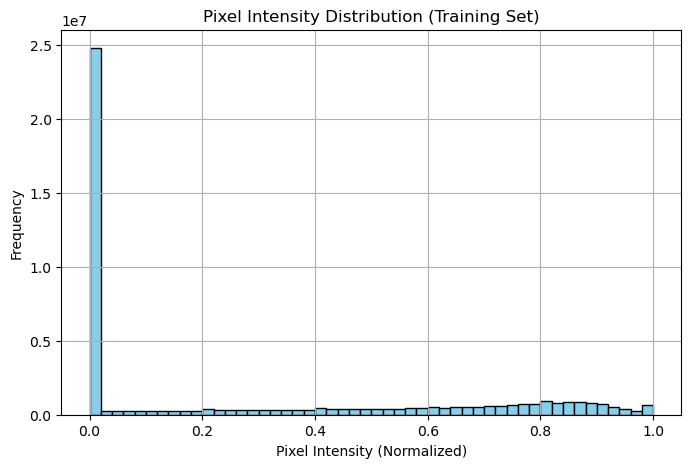

In [ ]:
# Flatten all training pixels into a 1D array
all_pixels = train_images.flatten()

# Plot histogram of pixel values to understand how grayscale intensities (0 to 255 → now scaled 0 to 1) are distributed across the dataset.
plt.figure(figsize=(8, 5))
plt.hist(all_pixels, bins=50, color='skyblue', edgecolor='black')
plt.title("Pixel Intensity Distribution (Training Set)")
plt.xlabel("Pixel Intensity (Normalized)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

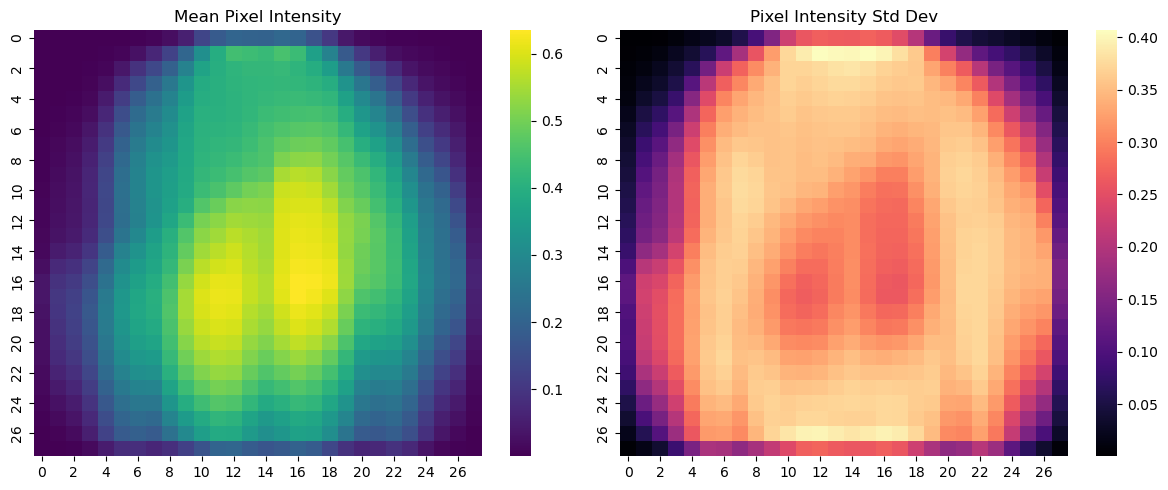

In [ ]:
# Mean and std of each pixel across all training images
pixel_mean = np.mean(train_images, axis=0)
pixel_std = np.std(train_images, axis=0)

# Plot heatmaps shows how much variation each pixel has across all images — useful for understanding structure in the image layout.
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.heatmap(pixel_mean, ax=axs[0], cmap='viridis')
axs[0].set_title("Mean Pixel Intensity")
sns.heatmap(pixel_std, ax=axs[1], cmap='magma')
axs[1].set_title("Pixel Intensity Std Dev")
plt.tight_layout()
plt.show()

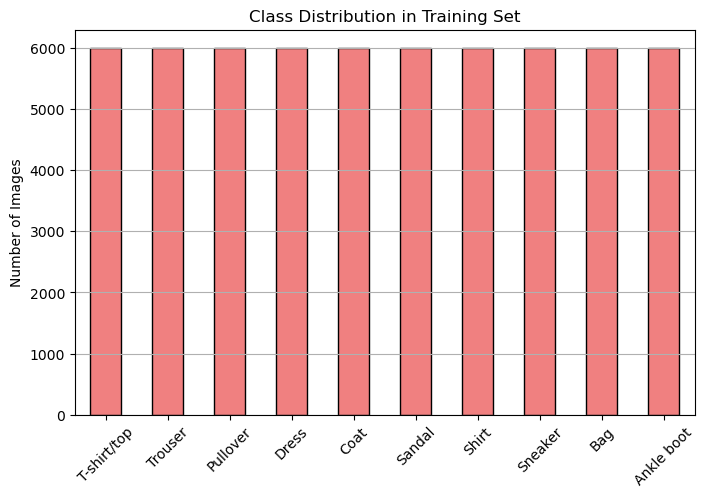

In [15]:
# Class names mapping
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Create a DataFrame for counts
label_counts = pd.Series(train_labels).value_counts().sort_index()
label_counts.index = class_names

# Plot
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

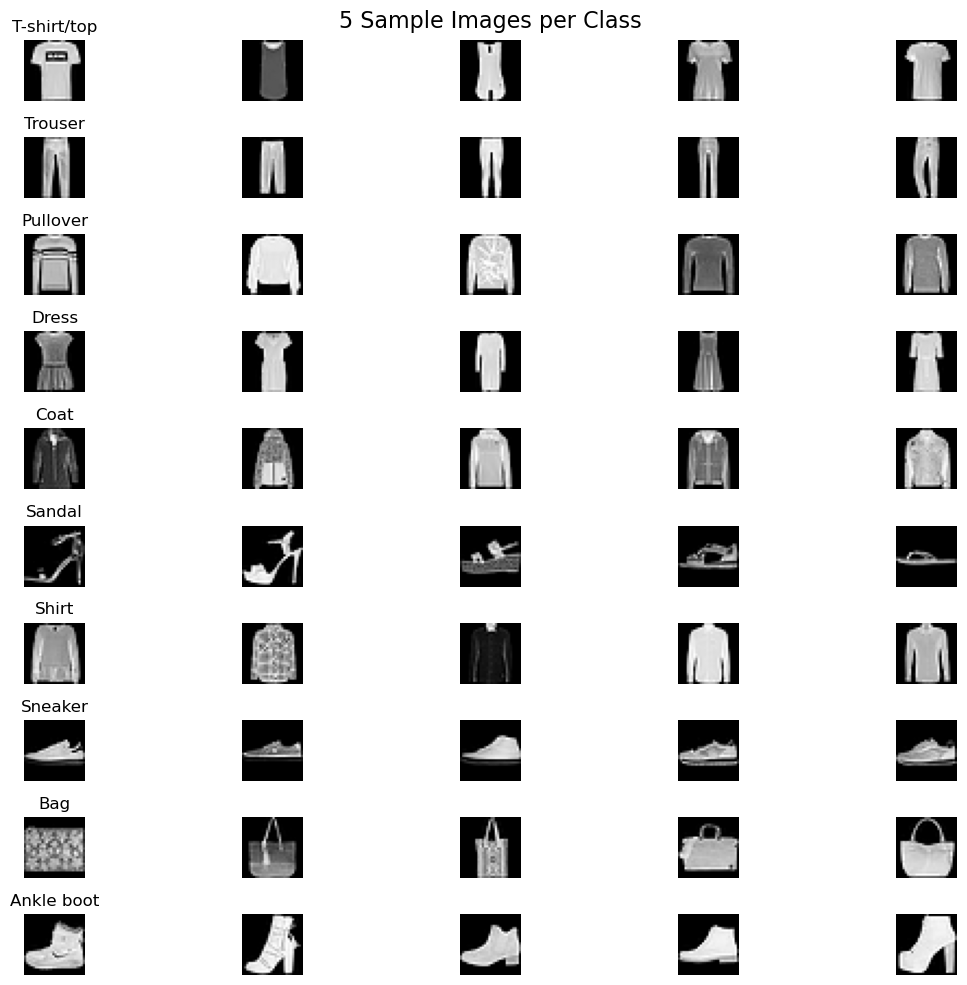

In [17]:
# Plot 5 samples per class
plt.figure(figsize=(12, 10))

for label in range(10):
    # Get indexes of images with this label
    idxs = np.where(train_labels == label)[0][:5]
    
    for i, idx in enumerate(idxs):
        plt_idx = label * 5 + i + 1
        plt.subplot(10, 5, plt_idx)
        plt.imshow(train_images[idx], cmap="gray")
        plt.axis("off")
        
        if i == 0:
            plt.title(class_names[label])

plt.suptitle("5 Sample Images per Class", fontsize=16)
plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()